In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
import matplotlib.backends.backend_pdf

In [3]:
cd ..

/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models


In [4]:
from mult_model_fns import *
from folic_acid.folic_acid_mult_model_fns import *

In [5]:
input_data_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [6]:
## GLOBALS

In [7]:
location_ids = pd.read_csv(input_data_path).location_id.unique().tolist()
location_ids

[161,
 201,
 202,
 205,
 171,
 179,
 163,
 11,
 180,
 184,
 15,
 164,
 214,
 165,
 196,
 190,
 189,
 20]

In [8]:
ages = [1,2,3,4,5]
sexes = [1,2]
ages = [2,3,4,5]

draws = [f'draw_{i}' for i in range(1_000)]
index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]

In [9]:
rei_id = [] #folic acid doesn't effect any risks; just NTDs
cause_ids = [642] # NTDs
nonfatal_causes = [642] # YLLs and YLDs
nutrient = 'folic acid'
vehicle = 'wheat flour' 

In [10]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

In [11]:
# calculate relative risk for lack of fortification
# https://vivarium-research.readthedocs.io/en/latest/concept_models/vivarium_conic_lsff/concept_model.html#effect-size-folic-acid
rr_ntds_nofort = format_rrs(lognormal_draws(mu, sigma, seed = 7), location_ids)
rr_ntds_nofort.mean(axis=1)

location_id
161    1.712028
201    1.712028
202    1.712028
205    1.712028
171    1.712028
179    1.712028
163    1.712028
11     1.712028
180    1.712028
184    1.712028
15     1.712028
164    1.712028
214    1.712028
165    1.712028
196    1.712028
190    1.712028
189    1.712028
20     1.712028
dtype: float64

In [12]:
data = pull_coverage_data(input_data_path, nutrient, vehicle, location_ids, 'wra')

In [13]:
data = create_marginal_uncertainty(data)

In [14]:
data.head()

,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile
3,161,Bangladesh,women of reproductive age,wheat flour,percent of population eating vehicle,na,41.900000,31.257526,52.542474
5,161,Bangladesh,NaN,wheat flour,percent of population eating industrially prod...,na,38.241333,28.528149,47.954517
6,161,Bangladesh,NaN,wheat flour,percent of population eating fortified vehicle,folic acid,0.155875,0.116283,0.195467
19,201,Burkina Faso,women of reproductive age,wheat flour,percent of population eating vehicle,na,48.000000,21.097889,74.902111
20,201,Burkina Faso,children 12-36 months,wheat flour,percent of population eating vehicle,na,57.000000,25.053743,88.946257


In [15]:
alpha, alpha_star = generate_coverage_tables(data, alternative_scenario_coverage_levels, seed = 11)

In [16]:
gets_intervn = prop_gets_intervention_effect(location_ids, year_start=2022, estimation_years = range(2022,2026))

In [17]:
new_coverage = percolate_new_coverage(gets_intervn, alpha, alpha_star)

In [18]:
paf_ntds_nofort = paf_o_r(rr_ntds_nofort, alpha)

In [19]:
paf_ntds_nofort.mean(axis=1)

location_id
161    0.411120
201    0.320472
202    0.173131
205    0.385072
171    0.411496
179    0.406558
163    0.396018
11     0.160753
180    0.313489
184    0.387067
15     0.406492
164    0.398968
214    0.368098
165    0.406818
196    0.397545
190    0.390268
189    0.319368
20     0.401499
dtype: float64

In [20]:
pif_ntds_nofort = pif_o_r(paf_ntds_nofort, alpha = alpha, alpha_star = new_coverage)

In [21]:
pif_ntds_nofort.head()

draw_0  draw_1  \
location_id year_id age_group_id sex_id coverage_level                   
11          2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_2  draw_3  \
location_id year_id age_group_id sex_id coverage_level                   
11          2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_4  draw_5  \
location_id year_id age_group_id sex_id coverage_level                   
11          2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_6  draw_7  \
location_id year_id age_group_id sex_id coverage_level                   
11          2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_8  draw_9  ...  \
location_id year_id age_group_id sex_id coverage_level                  ...   
11          2022    2            1      0.2                0.0     0.0  ...   
                                        0.5                0.0     0.0  ...   
                                        0.8                0.0     0.0  ...   
                                 2      0.2                0.0     0.0  ...   
                                        0.5                0.0     0.0  ...   

                                                        draw_990  draw_991  \
location_id year_id age_group_id sex_id coverage_level                       
11          2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                                        0.8                  0.0       0.0   
                                 2      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   

                                                        draw_992  draw_993  \
location_id year_id age_group_id sex_id coverage_level                       
11          2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                                        0.8                  0.0       0.0   
                                 2      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   

                                                        draw_994  draw_995  \
location_id year_id age_group_id sex_id coverage_level                       
11          2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                    

In [22]:
dalys = pull_dalys(cause_ids, cause_ids, location_ids, ages, sexes, index_cols)

In [23]:
dalys_averted = calc_dalys_averted(dalys, pif_ntds_nofort)

In [24]:
dalys_averted_u5 = dalys_averted.reset_index().groupby(['location_id','year_id','coverage_level']).sum()[draws]

In [25]:
dalys_averted_u5.head()

draw_0       draw_1        draw_2  \
location_id year_id coverage_level                                            
11          2022    0.2                 0.000000     0.000000      0.000000   
                    0.5                 0.000000     0.000000      0.000000   
                    0.8                 0.000000     0.000000      0.000000   
            2023    0.2             -4454.231822 -2990.104019  -5015.075198   
                    0.5            -11135.579556 -7475.260047 -12537.687994   

                                          draw_3        draw_4       draw_5  \
location_id year_id coverage_level                                            
11          2022    0.2                 0.000000      0.000000     0.000000   
                    0.5                 0.000000      0.000000     0.000000   
                    0.8                 0.000000      0.000000     0.000000   
            2023    0.2             -7360.924850  -4565.695043 -3720.813573   
                    0.5            -18402.312125 -11414.237607 -9302.033931   

                                         draw_6       draw_7       draw_8  \
location_id year_id coverage_level                                          
11          2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2            -2598.234352 -2405.688164 -3758.047876   
                    0.5            -6495.585881 -6014.220410 -9395.119689   

                                          draw_9  ...      draw_990  \
location_id year_id coverage_level                ...                 
11          2022    0.2                 0.000000  ...      0.000000   
                    0.5                 0.000000  ...      0.000000   
                    0.8                 0.000000  ...      0.000000   
            2023    0.2             -5632.841646  ...  -7610.351309   
                    0.5            -14082.104115  ... -19025.878272   

                                        draw_991      draw_992      draw_993  \
location_id year_id coverage_level                                             
11          2022    0.2                 0.000000      0.000000      0.000000   
                    0.5                 0.000000      0.000000      0.000000   
                    0.8                 0.000000      0.000000      0.000000   
            2023    0.2             -5993.585156  -5721.750811  -9037.400251   
                    0.5            -14983.962891 -14304.377027 -22593.500627   

                                       draw_994      draw_995      draw_996  \
location_id year_id coverage_level                                            
11          2022    0.2                0.000000      0.000000      0.000000   
                    0.5                0.000000      0.000000      0.000000   
                    0.8                0.000000      0.000000      0.000000   
            2023    0.2            -3981.033531  -5444.515632  -5233.113742   
                    0.5            -9952.583828 -13611.289081 -13082.784356   

                                        draw_997      draw_998     draw_999  
location_id year_id coverage_level                                           
11          2022    0.2                 0.000000      0.000000     0.000000  
                    0.5                 0.000000      0.000000     0.000000  
                    0.8                 0.000000      0.000000     0.000000  
            2023    0.2             -6457.414411  -4570.269198 -3388.218150  
                    0.5            -16143.536028 -11425.672995 -8470.545375  

[5 rows x 1000 columns]

In [26]:
dalys_averted_path = '/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models/folic_acid/tier1_2_3_4_wheat_flour_dalys_averted_folic_acid_03_29_2021.csv.csv'
dalys_averted_u5.to_csv(dalys_averted_path)

In [27]:
# collapse to summary stats
dalys_averted_u5['mean_value'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].mean(axis=1)
dalys_averted_u5['p025'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.025, axis=1)
dalys_averted_u5['p975'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.975, axis=1)

dalys_averted_u5 = dalys_averted_u5[['mean_value','p025','p975']]

dalys_averted_u5 = dalys_averted_u5.reset_index()

In [28]:
## add rates
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

dalys_averted_u5 = dalys_averted_u5.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

dalys_averted_u5['mean_dalys_per_100_000py'] = dalys_averted_u5.mean_value / dalys_averted_u5.population * 100_000
dalys_averted_u5['p025_dalys_per_100_000py'] = dalys_averted_u5.p025 / dalys_averted_u5.population * 100_000
dalys_averted_u5['p975_dalys_per_100_000py'] = dalys_averted_u5.p975 / dalys_averted_u5.population * 100_000

In [29]:
dalys_averted_u5.head()

,location_id,year_id,coverage_level,mean_value,p025,p975,population,mean_dalys_per_100_000py,p025_dalys_per_100_000py,p975_dalys_per_100_000py
0,11,2022,0.2,0.000000,0.000000,0.000000,1.970635e+07,0.000000,0.000000,0.000000
1,11,2022,0.5,0.000000,0.000000,0.000000,1.970635e+07,0.000000,0.000000,0.000000
2,11,2022,0.8,0.000000,0.000000,0.000000,1.970635e+07,0.000000,0.000000,0.000000
3,11,2023,0.2,-5508.381919,-9041.147398,-2841.594791,1.970635e+07,-27.952314,-45.879352,-14.419688
4,11,2023,0.5,-13770.954797,-22602.868494,-7103.986977,1.970635e+07,-69.880786,-114.698380,-36.049221


# viz results

In [30]:
# coverage_level_dict = {0.2:'low',0.5:'medium',0.8:'high'}
# dalys_averted_u5.coverage_level = dalys_averted_u5.coverage_level.map(coverage_level_dict)

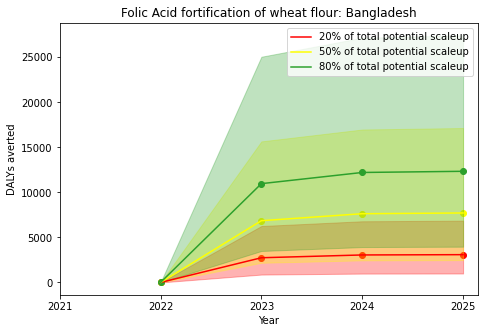

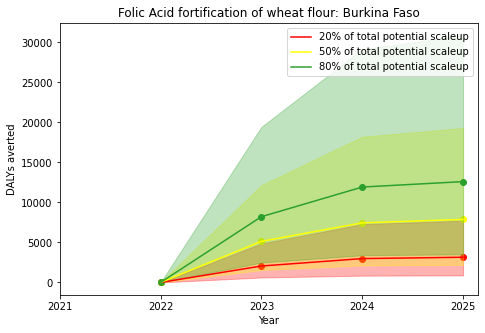

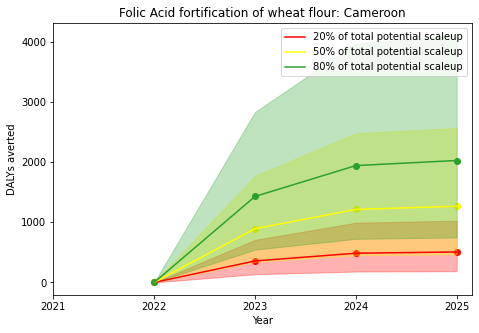

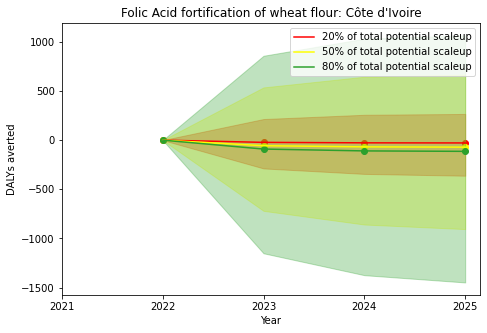

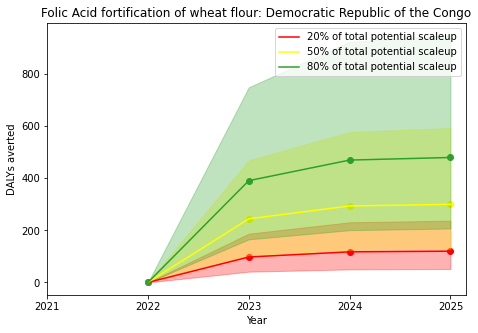

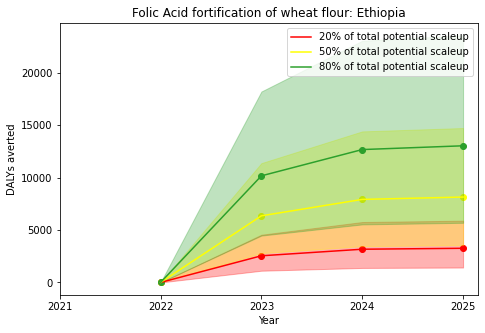

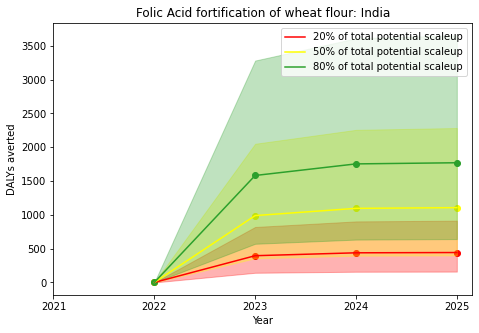

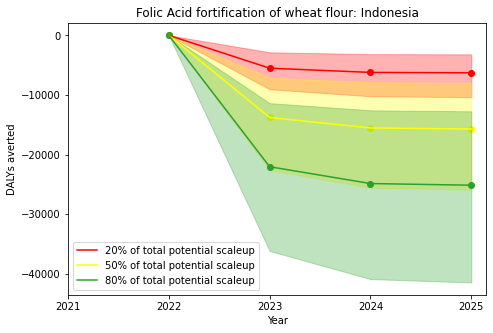

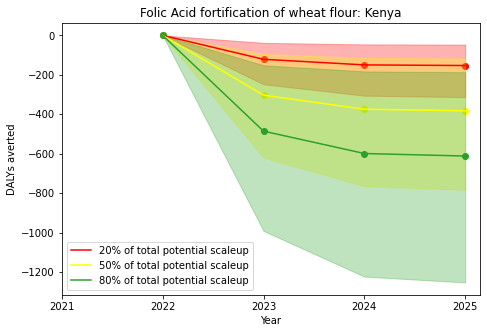

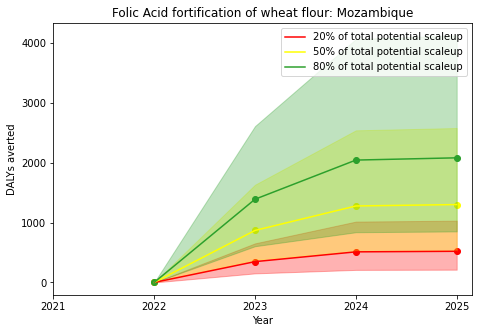

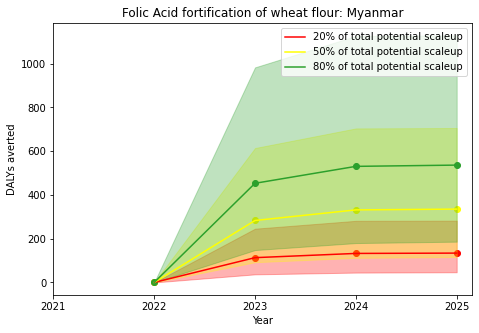

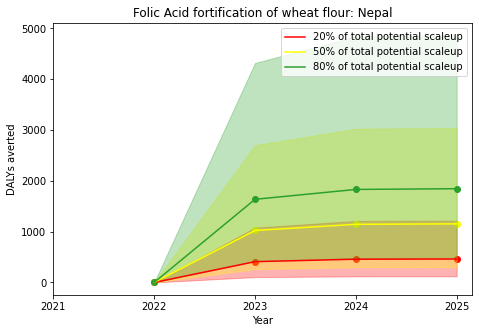

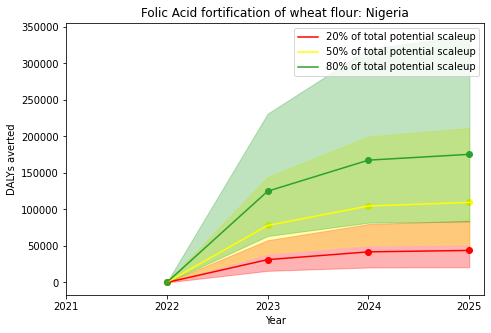

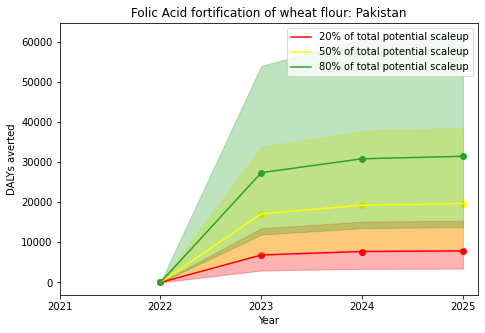

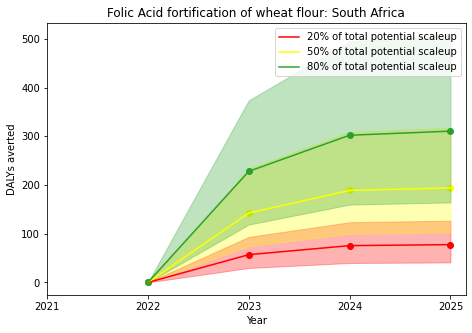

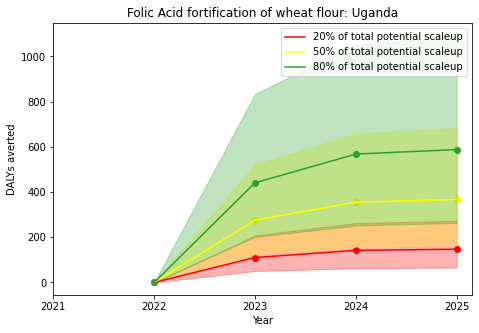

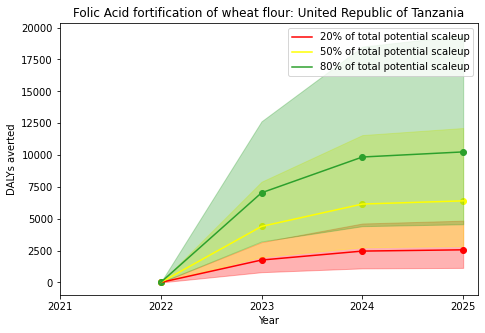

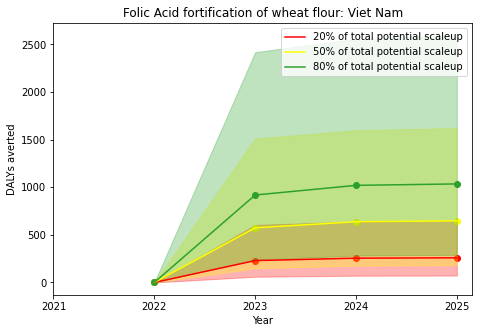

In [31]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}
    
    for loc in location_ids: #TODO: fix/requires global 'location_ids'
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{int(level*100)}% of total potential scaleup')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification of {vehicle}: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


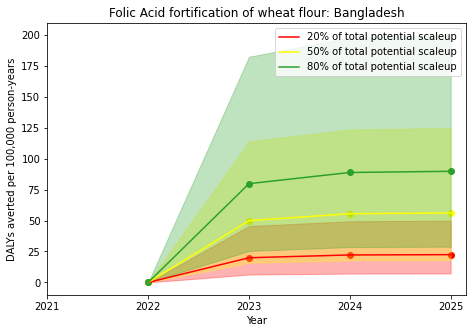

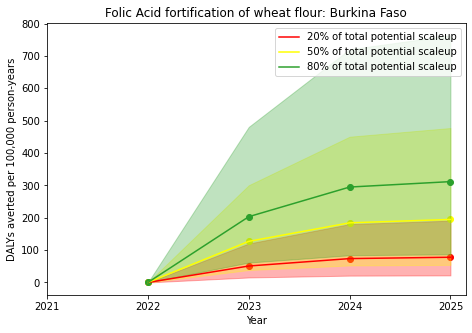

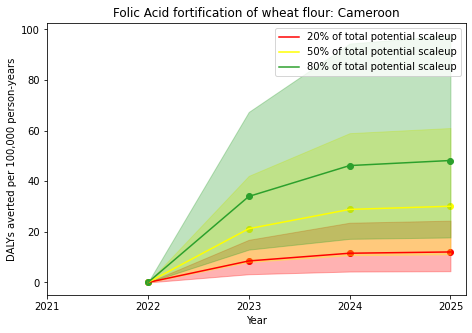

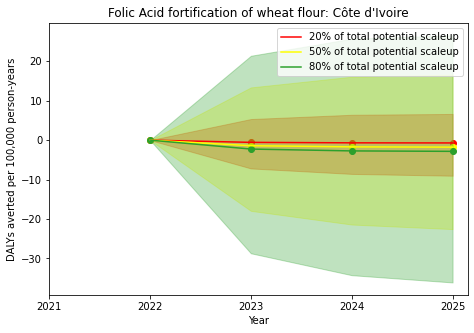

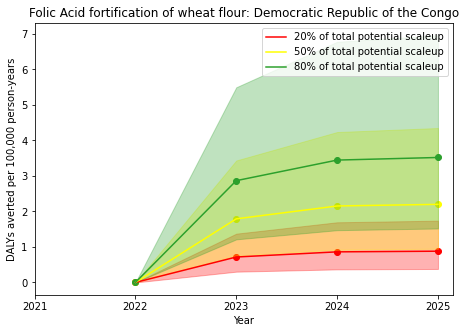

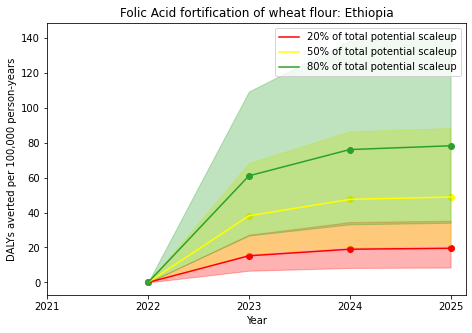

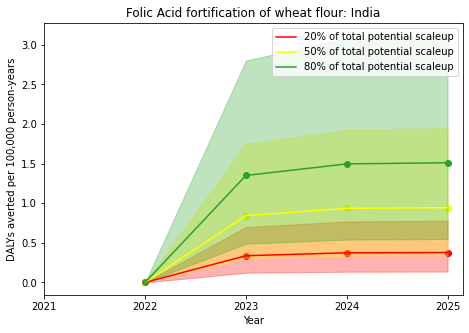

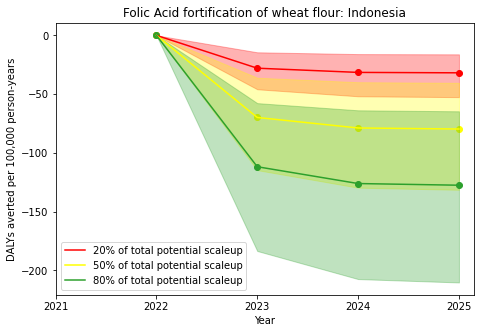

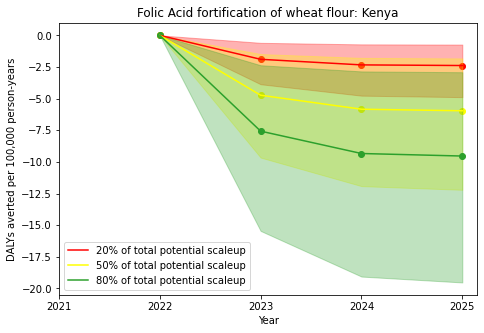

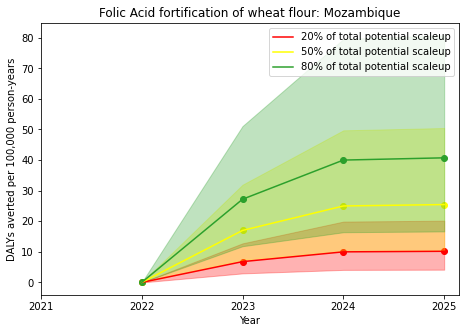

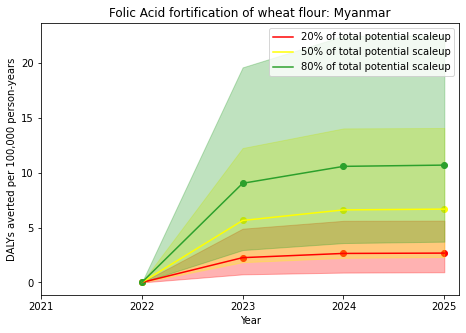

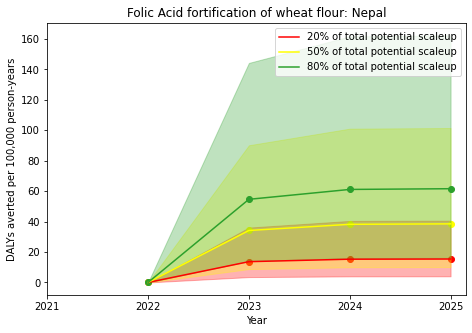

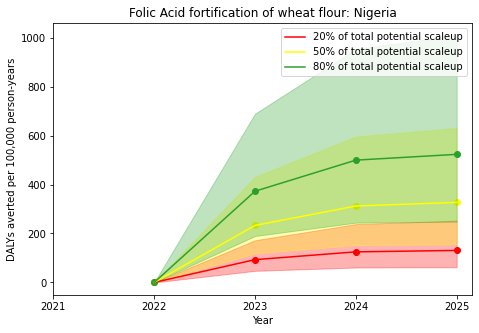

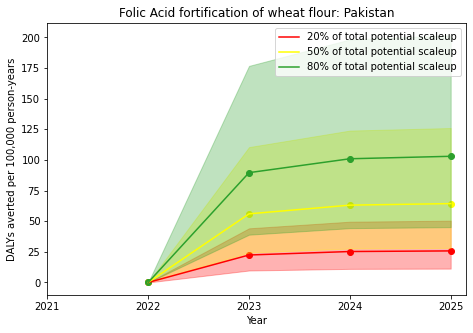

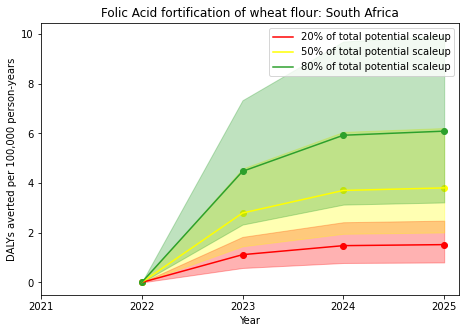

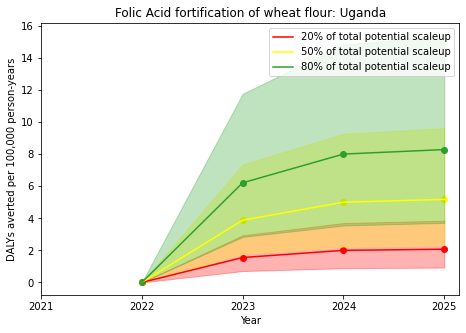

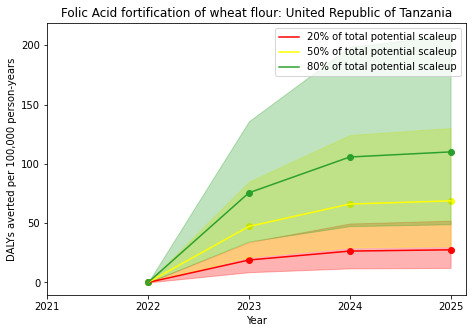

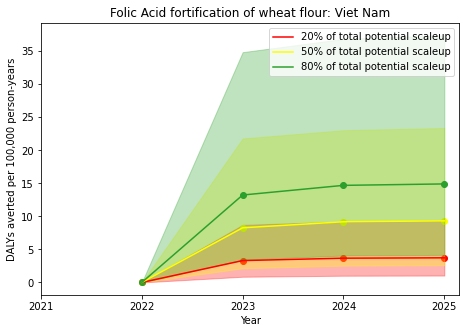

In [32]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}    
    for loc in location_ids:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{int(level*100)}% of total potential scaleup')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification of {vehicle}: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


In [33]:
# def plot_dalys_averted(save_path):
#     pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
#     location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick',
#               'hotpink','steelblue','cyan','lightsalmon','greenyellow','crimson','turquoise']

#     for level in alternative_scenario_coverage_levels:
#         fig, ax = plt.subplots(figsize=(7.5, 5))
#         for i in range(len(location_ids)):
#             loc = location_ids[i]
            
#             plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[i])
#             plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[i], label = location_names[loc])
#             plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[i])
#             plt.ylabel('DALYs averted')
#             plt.xlabel('Year')
#             plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
#             plt.legend()
#             plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
#         pdf.savefig(fig)
    
#     plt.show()
#     pdf.close()

# save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
# plot_dalys_averted(save_path)


In [34]:
# def plot_dalys_averted_rate(save_path):
#     pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
#     location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick',
#               'hotpink','steelblue','cyan','lightsalmon','greenyellow','crimson','turquoise']

#     for level in alternative_scenario_coverage_levels:
#         fig, ax = plt.subplots(figsize=(7.5, 5))
#         for i in range(len(location_ids)):
#             loc = location_ids[i]

#             plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[i])
#             plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[i], label = location_names[loc])
#             plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[i])
#             plt.ylabel('DALYs averted per 100,000 person-years')
#             plt.xlabel('Year')
#             plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
#             plt.legend()
#             plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
#         pdf.savefig(fig)

#     plt.show()
#     pdf.close()

# save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
# plot_dalys_averted_rate(save_path)

In [35]:
# this is why kenya is negative
inputs = pd.read_csv(input_data_path)

inputs[(inputs.location_name=="Kenya") & (inputs.nutrient=="folic acid")]



,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile
99,180,Kenya,NaN,maize flour,percent of population eating fortified vehicle,folic acid,0.000000,0.00000,0.000000
108,180,Kenya,NaN,wheat flour,percent of population eating fortified vehicle,folic acid,34.703333,15.25348,54.153186


In [36]:
inputs[(inputs.location_name=="Kenya") & (inputs.vehicle.isin(['maize flour','wheat flour'])) & (inputs.value_description=="percent of population eating industrially produced vehicle")]

,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile
98,180,Kenya,total population,maize flour,percent of population eating industrially prod...,na,36.67,17.221861,56.118139
107,180,Kenya,total population,wheat flour,percent of population eating industrially prod...,na,30.95,13.603743,48.296257
